MILESTONE 1:
SUBTASK 1 - Environment setup with LangGraph, LangChain, and Pinecone vector database -->

In [ ]:
import os
import json
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
import sys
print(sys.executable)

# LANGCHAIN SETUP
import subprocess

def pip_install(packages):
    subprocess.check_call([sys.executable, "-m", "pip", "install", *packages])

try:
    from langchain_text_splitters import RecursiveCharacterTextSplitter

    from langchain_community.embeddings import HuggingFaceEmbeddings

except Exception:
    pip_install(["langchain", "sentence-transformers", "transformers", "tqdm"])
    from langchain_text_splitters import RecursiveCharacterTextSplitter

    from langchain.embeddings import HuggingFaceEmbeddings

print("Imports OK")


In [37]:
# Pinecone Setup

import os
import json
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from pinecone import Pinecone, ServerlessSpec
from sentence_transformers import SentenceTransformer
from dotenv import load_dotenv

load_dotenv()

assert "PINECONE_API_KEY" in os.environ, "PINECONE_API_KEY not found"

print("Pinecone API key loaded successfully")

pc = Pinecone(api_key=os.environ["PINECONE_API_KEY"])

model = SentenceTransformer("all-MiniLM-L6-v2")

print("Sentence-Transformer model loaded successfully")


Pinecone API key loaded successfully
Sentence-Transformer model loaded successfully


Sentence-Transformer model (all-MiniLM-L6-v2) used because its specifically trained for embeddings and therefore gives us good results.

In [43]:
INDEX_NAME = "cuad-index-minilm"   
DIMENSION = 384                  

existing_indexes = [idx["name"] for idx in pc.list_indexes()]

if INDEX_NAME not in existing_indexes:
    pc.create_index(
        name=INDEX_NAME,
        dimension=DIMENSION,
        metric="cosine",
        spec=ServerlessSpec(
            cloud="aws",
            region="us-east-1"
        )
    )

index = pc.Index(INDEX_NAME)

print(f"Connected to Pinecone index: {INDEX_NAME}")


Connected to Pinecone index: cuad-index-minilm


Created and connected to Pinecone index cuad-index using cosine similarity for semantic search.

SUBTASK 2 - Implement document upload and basic parsing of contract text -->

EDA on master_clauses.csv

In [2]:
#EDA on master_clauses.csv
csv_path = "../Data/Raw/master_clauses.csv"
df = pd.read_csv(csv_path)

df.head()

,Filename,Document Name,Document Name-Answer,Parties,Parties-Answer,Agreement Date,Agreement Date-Answer,Effective Date,Effective Date-Answer,Expiration Date,...,Liquidated Damages,Liquidated Damages-Answer,Warranty Duration,Warranty Duration-Answer,Insurance,Insurance-Answer,Covenant Not To Sue,Covenant Not To Sue-Answer,Third Party Beneficiary,Third Party Beneficiary-Answer
0,CybergyHoldingsInc_20140520_10-Q_EX-10.27_8605...,['MARKETING AFFILIATE AGREEMENT'],MARKETING AFFILIATE AGREEMENT,"['BIRCH FIRST GLOBAL INVESTMENTS INC.', 'MA', ...","Birch First Global Investments Inc. (""Company""...","['8th day of May 2014', 'May 8, 2014']",5/8/14,['This agreement shall begin upon the date of ...,NaN,['This agreement shall begin upon the date of ...,...,[],No,"[""COMPANY'S SOLE AND EXCLUSIVE LIABILITY FOR T...",Yes,[],No,[],No,[],No
1,EuromediaHoldingsCorp_20070215_10SB12G_EX-10.B...,['VIDEO-ON-DEMAND CONTENT LICENSE AGREEMENT'],VIDEO-ON-DEMAND CONTENT LICENSE AGREEMENT,"['EuroMedia Holdings Corp.', 'Rogers', 'Rogers...","Rogers Cable Communications Inc. (""Rogers""); E...","['July 11 , 2006']",7/11/06,"['July 11 , 2006']",7/11/06,"['The term of this Agreement (the ""Initial Ter...",...,[],No,[],No,[],No,[],No,[],No
2,FulucaiProductionsLtd_20131223_10-Q_EX-10.9_83...,['CONTENT DISTRIBUTION AND LICENSE AGREEMENT'],CONTENT DISTRIBUTION AND LICENSE AGREEMENT,"['Producer', 'Fulucai Productions Ltd.', 'Conv...","CONVERGTV, INC. (“ConvergTV”); Fulucai Product...","['November 15, 2012']",11/15/12,"['November 15, 2012']",11/15/12,[],...,[],No,[],No,[],No,[],No,[],No
3,GopageCorp_20140221_10-K_EX-10.1_8432966_EX-10...,['WEBSITE CONTENT LICENSE AGREEMENT'],WEBSITE CONTENT LICENSE AGREEMENT,"['PSiTech Corporation', 'Licensor', 'Licensee'...","PSiTech Corporation (""Licensor""); Empirical Ve...","['Feb 10, 2014']",2/10/14,"['Feb 10, 2014']",2/10/14,['The initial term of this Agreement commences...,...,[],No,[],No,[],No,[],No,[],No
4,IdeanomicsInc_20160330_10-K_EX-10.26_9512211_E...,['CONTENT LICENSE AGREEMENT'],CONTENT LICENSE AGREEMENT,"['YOU ON DEMAND HOLDINGS, INC.', 'Licensor', '...",Beijing Sun Seven Stars Culture Development Li...,"['December 21, 2015']",12/21/15,"['December 21, 2015']",12/21/15,"['The Term of this Agreement (the ""Term"") shal...",...,[],No,[],No,[],No,[],No,[],No


The master_clause.csv file is loaded and read. The first 5 files data has been shown.

In [3]:
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510 entries, 0 to 509
Data columns (total 83 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   Filename                                    510 non-null    object
 1   Document Name                               510 non-null    object
 2   Document Name-Answer                        510 non-null    object
 3   Parties                                     510 non-null    object
 4   Parties-Answer                              509 non-null    object
 5   Agreement Date                              510 non-null    object
 6   Agreement Date-Answer                       465 non-null    object
 7   Effective Date                              510 non-null    object
 8   Effective Date-Answer                       359 non-null    object
 9   Expiration Date                             510 non-null    object
 10  Expiration Date-Answer    

The Master_Clause.csv file contains 510 Rows and 83 columns.

In [4]:
# null values count
df.isnull().sum()

Filename                          0
Document Name                     0
Document Name-Answer              0
Parties                           0
Parties-Answer                    1
                                 ..
Insurance-Answer                  0
Covenant Not To Sue               0
Covenant Not To Sue-Answer        0
Third Party Beneficiary           0
Third Party Beneficiary-Answer    0
Length: 83, dtype: int64

There are 83 null values in this csv file.

EDA on CUAD_v1.json

In [5]:
#EDA on CUAD_v1.json
json_path = "../Data/Raw/CUAD_v1.json"

with open(json_path, "r", encoding="utf-8") as f:
    cuad_json = json.load(f)

type(cuad_json)


dict

The file data is in the form of dictionary.

In [6]:
cuad_json.keys()

dict_keys(['version', 'data'])

The file has two fields - "data" and "version".

In [7]:
len(cuad_json["data"])

510

The total number of contracts in the datase - cuad_v1.json file is 510.

In [8]:
cuad_json["data"][0].keys()

dict_keys(['title', 'paragraphs'])

Each individual contract entry in CUAD_v1.json is a dictionary. Every contract has two fields - title, paragraphs

In [9]:
total_qas = 0

for contract in cuad_json["data"]:
    for paragraph in contract["paragraphs"]:
        total_qas += len(paragraph["qas"])

total_qas


20910

The total number of annotated question–answer pairs are 20910.

BASIC EDA on full_contract_txt folder

In [ ]:
# BASIC EDA on full_contract_txt folder
txt_folder = "../Data/Raw/full_contract_txt"
txt_files = os.listdir(txt_folder)

len(txt_files)


510

There are 510 files in the full_contract_txt folder.

In [11]:
sample_file = txt_files[0]
sample_path = os.path.join(txt_folder, sample_file)

with open(sample_path, "r", encoding="utf-8") as f:
    text = f.read()

len(text.split())

4467

The 1st contract contains 4,467 words. This means that individual legal contracts in CUAD are very long and dense.

In [12]:
txt_files[:10]

['2ThemartComInc_19990826_10-12G_EX-10.10_6700288_EX-10.10_Co-Branding Agreement_ Agency Agreement.txt',
 'ABILITYINC_06_15_2020-EX-4.25-SERVICES AGREEMENT.txt',
 'ACCELERATEDTECHNOLOGIESHOLDINGCORP_04_24_2003-EX-10.13-JOINT VENTURE AGREEMENT.txt',
 'ACCURAYINC_09_01_2010-EX-10.31-DISTRIBUTOR AGREEMENT.txt',
 'ADAMSGOLFINC_03_21_2005-EX-10.17-ENDORSEMENT AGREEMENT.txt',
 'ADAPTIMMUNETHERAPEUTICSPLC_04_06_2017-EX-10.11-STRATEGIC ALLIANCE AGREEMENT.txt',
 'ADIANUTRITION,INC_04_01_2005-EX-10.D2-RESELLER AGREEMENT.txt',
 'ADMA BioManufacturing, LLC -  Amendment #3 to Manufacturing Agreement .txt',
 'ADUROBIOTECH,INC_06_02_2020-EX-10.7-CONSULTING AGREEMENT(1).txt',
 'ADUROBIOTECH,INC_06_02_2020-EX-10.7-CONSULTING AGREEMENT.txt']

These are the first 10 files in the folder.

In [13]:
word_counts = []

for file in txt_files:
    path = os.path.join(txt_folder, file)
    with open(path, "r", encoding="utf-8") as f:
        text = f.read()
        word_counts.append(len(text.split()))

word_counts[:10]  # show first few


[4467, 4115, 1911, 13349, 3770, 15471, 4051, 2478, 1850, 1850]

The number of words in the first 10 processed files are the output of this code.

Advanced EDA

In [1]:
# ADVANCED EDA:
#Count words per contract (5 files taken for now)
import os
import pandas as pd

txt_folder = "../Data/Raw/full_contract_txt"

file_stats = []

for file in os.listdir(txt_folder):
    path = os.path.join(txt_folder, file)
    with open(path, "r", encoding="utf-8") as f:
        text = f.read()
        word_count = len(text.split())
        file_stats.append({"contract": file, "word_count": word_count})

df_len = pd.DataFrame(file_stats)
df_len.head()


,contract,word_count
0,2ThemartComInc_19990826_10-12G_EX-10.10_670028...,4467
1,ABILITYINC_06_15_2020-EX-4.25-SERVICES AGREEME...,4115
2,ACCELERATEDTECHNOLOGIESHOLDINGCORP_04_24_2003-...,1911
3,ACCURAYINC_09_01_2010-EX-10.31-DISTRIBUTOR AGR...,13349
4,ADAMSGOLFINC_03_21_2005-EX-10.17-ENDORSEMENT A...,3770


All the files are processed but the only the word count of first 5 files are returned using .head() since default n=5.

In [2]:
#Find most frequent legal terms
from collections import Counter

keywords = ["agreement", "party", "termination", "confidentiality", "liability",
            "indemnification", "warranty", "law", "notice", "payment",
            "renewal", "governing", "assignment", "expiration"]

term_counts = Counter()

for file in os.listdir(txt_folder):
    path = os.path.join(txt_folder, file)
    with open(path, "r", encoding="utf-8") as f:
        text = f.read().lower()
        for term in keywords:
            if term in text:
                term_counts[term] += 1

term_counts


Counter({'agreement': 507,
         'party': 476,
         'law': 471,
         'notice': 451,
         'termination': 447,
         'payment': 422,
         'liability': 411,
         'assignment': 367,
         'confidentiality': 330,
         'expiration': 323,
         'governing': 319,
         'indemnification': 285,
         'warranty': 275,
         'renewal': 189})

These are some comman keywords which are used in the legal contracts. In our folder, the number of times each keyword is used in all the files are mentioned.

In [3]:
#Empty or short agreements
empty_files = df_len[df_len["word_count"] < 50]
empty_files

,contract,word_count


The empty table shows that are empty or very short files.

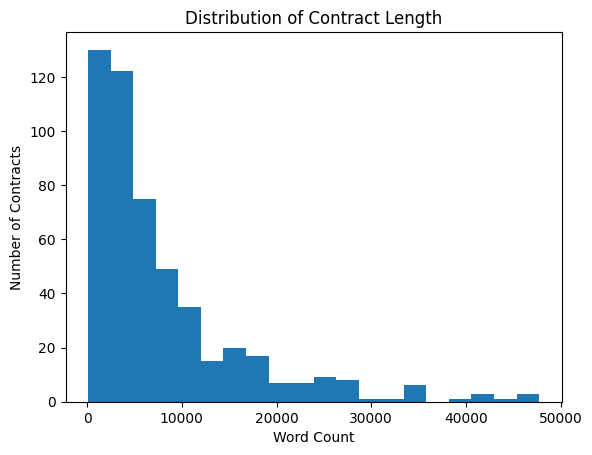

In [4]:
# Histogram of word counts
import matplotlib.pyplot as plt

plt.hist(df_len["word_count"], bins=20)
plt.xlabel("Word Count")
plt.ylabel("Number of Contracts")
plt.title("Distribution of Contract Length")
plt.show()


The histogram tells the distribution of contract lengths across the dataset.  
Most contracts have between 1,000 and 10,000 words.
A smaller portion of contracts have 20,000–40,000 words, indicating that very long and detailed agreements are present in the folder.

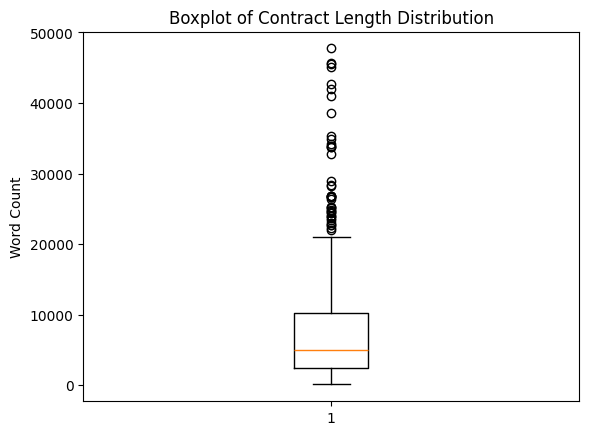

In [5]:
plt.boxplot(df_len["word_count"])
plt.ylabel("Word Count")
plt.title("Boxplot of Contract Length Distribution")
plt.show()

The boxplot shows a concentration of contract lengths around the median, along with a large number of long-document outliers, showing variety in document size.

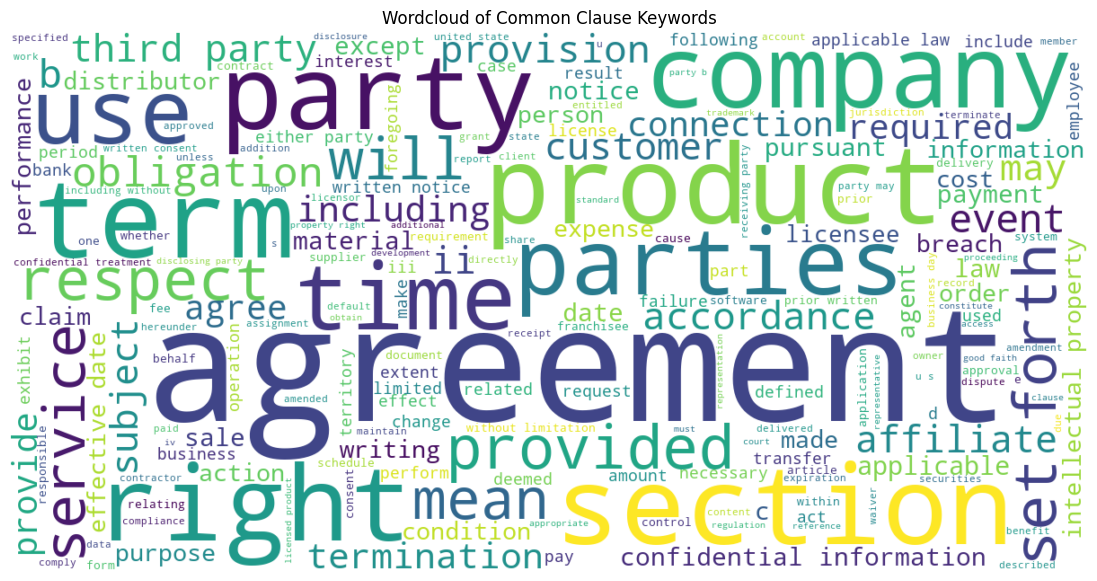

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import os

txt_folder = "../Data/Raw/full_contract_txt"
corpus = ""

for file in os.listdir(txt_folder):
    path = os.path.join(txt_folder, file)
    with open(path, "r", encoding="utf-8") as f:
        corpus += " " + f.read().lower()


wc = WordCloud(
    width=1200,
    height=600,
    background_color="white",
    max_words=200
).generate(corpus)

plt.figure(figsize=(14, 7))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Wordcloud of Common Clause Keywords")
plt.show()



The wordcloud highlights frequently appearing legal terms such as *agreement, parties, service, termination and section. This confirms strong understanding of key legal concepts present in the dataset.

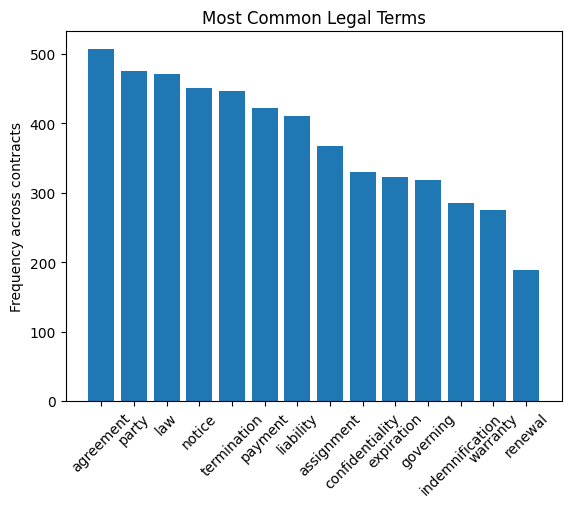

In [9]:
#Bar chart
terms, counts = zip(*term_counts.most_common())

plt.bar(terms, counts)
plt.xticks(rotation=45)
plt.ylabel("Frequency across contracts")
plt.title("Most Common Legal Terms")
plt.show()

This graph shows the relationship of the frequently occuring terms in the contracts with their occurance frequency. the term 'agreement' is used the most while the term 'renewel' is used the least number of times.

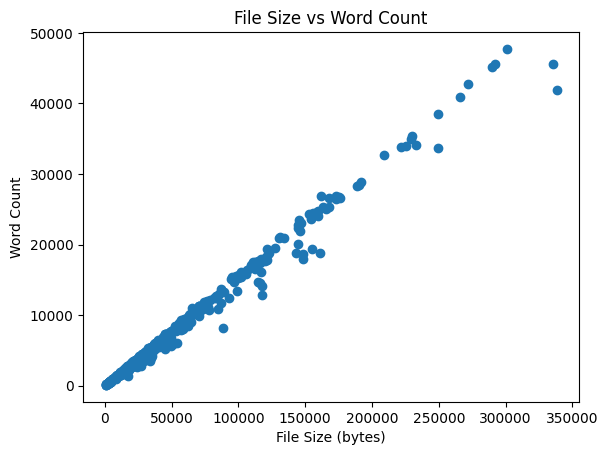

In [10]:
#Scatter plot
file_sizes = []
for file in os.listdir(txt_folder):
    path = os.path.join(txt_folder, file)
    file_sizes.append((file, os.path.getsize(path)))

df_sizes = pd.DataFrame(file_sizes, columns=["contract", "file_size"])

merged = df_len.merge(df_sizes, on="contract")

plt.scatter(merged["file_size"], merged["word_count"])
plt.xlabel("File Size (bytes)")
plt.ylabel("Word Count")
plt.title("File Size vs Word Count")
plt.show()

The scatter plot shows a strong positive correlation between file size and word count.  
As the file size increases, the number of words in a contract increases as well.

In [11]:
import re

# Normalize whitespace
text = re.sub(r"\s+", " ", text).strip()

print(text[:200]) 


exhibit 10.10 road transportation agreement party a (shipper): zto express co., ltd. address: building 1, no. 1685, huazhi road, huaxin twon, qingpu district, shanghai party b (carrier): tonglu tongze


Multiple spaces, tabs, and newline characters were normalized into a single space, improving text uniformity without altering meaning.

In [12]:
# Remove repeated line breaks
text = text.replace("\r\n", "\n").replace("\r", "\n")
text = re.sub(r"\n{3,}", "\n\n", text)

print(text[:500])


exhibit 10.10 road transportation agreement party a (shipper): zto express co., ltd. address: building 1, no. 1685, huazhi road, huaxin twon, qingpu district, shanghai party b (carrier): tonglu tongze logistics ltd. address: 12 floor, hsbc tower, yinchun south road, tonglu county, zhejiang province due to the need for logistics business, party a and party b enter into this road transportation agreement (this "agreement"), in which party a pays the freight and party b provides parcel transportati


Different newline representations coverted to `\n` and long runs of blank lines reduced.

In [13]:
#Remove noisy characters
text = (
    text
    .replace("•", " ")
    .replace("●", " ")
    .replace("○", " ")
)

# keep printable ASCII + newlines
text = re.sub(r"[^\x0A\x20-\x7E]", " ", text)

print(text[:500])


exhibit 10.10 road transportation agreement party a (shipper): zto express co., ltd. address: building 1, no. 1685, huazhi road, huaxin twon, qingpu district, shanghai party b (carrier): tonglu tongze logistics ltd. address: 12 floor, hsbc tower, yinchun south road, tonglu county, zhejiang province due to the need for logistics business, party a and party b enter into this road transportation agreement (this "agreement"), in which party a pays the freight and party b provides parcel transportati


Bullet characters and non-ASCII symbols were removed/replaced with spaces to reduce formatting noise while keeping readable contractual text unchanged.  
This helps ensure cleaner tokenization without changing the meaning or structure of the document.

In [14]:
# Fix hyphenation across lines
text = re.sub(r"(\w+)-\s+(\w+)", r"\1\2", text)

print(text[:500])

exhibit 10.10 road transportation agreement party a (shipper): zto express co., ltd. address: building 1, no. 1685, huazhi road, huaxin twon, qingpu district, shanghai party b (carrier): tonglu tongze logistics ltd. address: 12 floor, hsbc tower, yinchun south road, tonglu county, zhejiang province due to the need for logistics business, party a and party b enter into this road transportation agreement (this "agreement"), in which party a pays the freight and party b provides parcel transportati


Hyphenated line-break splits were fixed so that words split across lines (e.g.`termi-\nnation`) are merged back into a single token (`termination`).  
This preserves word meaning and improves the quality of tokenization.

In [15]:
# Standardize casing: lower text except fully UPPERCASE headers

def preserve_headers(text):
    lines = text.split("\n")
    processed = []
    for line in lines:
        if line.strip().isupper():      # keep section header casing
            processed.append(line.strip())
        else:
            processed.append(line.lower())
    return "\n".join(processed)

text1 = preserve_headers(text)
print(text1[:500])


exhibit 10.10 road transportation agreement party a (shipper): zto express co., ltd. address: building 1, no. 1685, huazhi road, huaxin twon, qingpu district, shanghai party b (carrier): tonglu tongze logistics ltd. address: 12 floor, hsbc tower, yinchun south road, tonglu county, zhejiang province due to the need for logistics business, party a and party b enter into this road transportation agreement (this "agreement"), in which party a pays the freight and party b provides parcel transportati


Casing was standardized by converting general body text to lowercase while preserving fully uppercase section headers such as “TERMINATION” and “CONFIDENTIALITY”.  
This improves textual consistency without losing document structure or semantic cues important for clause identification.

In [16]:
# ensure two newlines after major section headers
text2 = re.sub(r"([A-Z ]{5,})\n", r"\1\n\n", text1)

print(text2[:500])


exhibit 10.10 road transportation agreement party a (shipper): zto express co., ltd. address: building 1, no. 1685, huazhi road, huaxin twon, qingpu district, shanghai party b (carrier): tonglu tongze logistics ltd. address: 12 floor, hsbc tower, yinchun south road, tonglu county, zhejiang province due to the need for logistics business, party a and party b enter into this road transportation agreement (this "agreement"), in which party a pays the freight and party b provides parcel transportati


Section boundaries were preserved by inserting extra spacing after major clause headers.  
This ensures that important contract structure (e.g., clause titles and sections) remains recognizable for downstream parsing.

In [ ]:
import re

def clean_contract_text(text: str) -> str:
    # Step 1: remove simple headers/footers
    lines = text.splitlines()
    cleaned_lines = []
    for line in lines:
        stripped = line.strip()
        if re.fullmatch(r"\d+", stripped):
            continue
        if re.fullmatch(r"page\s+\d+(\s+of\s+\d+)?", stripped, flags=re.IGNORECASE):
            continue
        cleaned_lines.append(line)
    text = "\n".join(cleaned_lines)

    # Step 2: normalize whitespace
    text = text.replace("\t", " ")
    text = re.sub(r"[ ]{2,}", " ", text)

    # Step 3: normalize line breaks
    text = text.replace("\r\n", "\n").replace("\r", "\n")
    text = re.sub(r"\n{3,}", "\n\n", text)

    # Step 4: remove noisy / non-ASCII characters & bullets
    text = (
        text
        .replace("•", " ")
        .replace("●", " ")
        .replace("○", " ")
    )
    text = re.sub(r"[^\x0A\x20-\x7E]", " ", text)

    # Step 5: fix hyphenation across lines
    text = re.sub(r"(\w+)-\s+(\w+)", r"\1\2", text)

    # Step 6: trim outer whitespace (keep original case)
    text = text.strip()

    return text

In [ ]:
clean_folder = "../Data/Transform/contract_id_cleaned"
os.makedirs(clean_folder, exist_ok=True)

for fname in os.listdir(txt_folder):
    src_path = os.path.join(txt_folder, fname)
    with open(src_path, "r", encoding="utf-8") as f:
        raw_text = f.read()

    cleaned_text = clean_contract_text(raw_text)

    base, ext = os.path.splitext(fname)
    dst_path = os.path.join(clean_folder, f"{base}_cleaned{ext}")

    with open(dst_path, "w", encoding="utf-8") as f:
        f.write(cleaned_text)

Pinecone task continuation from getting chunked files

In [6]:
# Get chunked files for pinecone
CHUNK_FOLDER = "../Data/chunk"

chunk_files = sorted(
    f for f in os.listdir(CHUNK_FOLDER) if f.endswith("_chunks.json")
)

len(chunk_files), chunk_files[:3]


(510,
 ['2ThemartComInc_19990826_10-12G_EX-10.10_6700288_EX-10.10_Co-Branding Agreement_ Agency Agreement_cleaned_chunks.json',
  'ABILITYINC_06_15_2020-EX-4.25-SERVICES AGREEMENT_cleaned_chunks.json',
  'ACCELERATEDTECHNOLOGIESHOLDINGCORP_04_24_2003-EX-10.13-JOINT VENTURE AGREEMENT_cleaned_chunks.json'])

first 5 chunked files are shown for the pinecone.

In [ ]:
vectors = []

for file in tqdm(chunk_files[:20], desc="Preparing vectors"):
    data = json.load(open(os.path.join(CHUNK_FOLDER, file), "r", encoding="utf-8"))
    contract_id = data["contract_id"]

    for chunk in data["chunks"]:
        embedding = embed_text(chunk["text"])

        vectors.append({
            "id": f"{contract_id}_chunk_{chunk['chunk_id']}",
            "values": embedding,
            "metadata": {
                "contract_id": contract_id,
                "chunk_id": chunk["chunk_id"],
                "text": chunk["text"][:1000]
            }
        })

len(vectors)


Vectors are created for the chunked files which contains id, values, metadata.

In [9]:
# Upsert vectors into Pinecone index
BATCH_SIZE = 100

for i in range(0, len(vectors), BATCH_SIZE):
    batch = vectors[i:i + BATCH_SIZE]
    index.upsert(vectors=batch)

print("Upsert completed.")


Upsert completed.


Upserted chunk-level embeddings into the Pinecone index to enable semantic retrieval.

In [ ]:
query_text = "termination clause with prior notice"

query_embedding = embed_text(query_text)

results = index.query(
    vector=query_embedding,
    top_k=5,
    include_metadata=True
)


In [ ]:
# Pretty Print To Rep 5 results
for rank, match in enumerate(results["matches"], start=1):
    print(f"\nRank {rank}")
    print("Score:", round(match["score"], 4))
    print("Contract ID:", match["metadata"]["contract_id"])
    print("Chunk ID:", match["metadata"]["chunk_id"])
    print("Text Preview:", match["metadata"]["text"][:300])


In [ ]:
scores = [m["score"] for m in results["matches"]]

import matplotlib.pyplot as plt

plt.bar(range(1, len(scores)+1), scores)
plt.xlabel("Rank")
plt.ylabel("Cosine Similarity Score")
plt.title("Top-K Similarity Scores")
plt.show()


SUBTASK 3 - Define the role structure for AI analyst agents (Compliance, Finance, Legal, 
Operations) -->

In [23]:
CLEAN_FOLDER = "../Data/Transform/contract_id_cleaned" 
CHUNK_FOLDER = "../Data/chunk"
EMBED_FOLDER = "../Data/embeddings"

CHUNK_SIZE = 1000
CHUNK_OVERLAP = 200
SEPARATORS = ["\n\n", "\n", ". ", " "]

os.makedirs(CHUNK_FOLDER, exist_ok=True)
os.makedirs(EMBED_FOLDER, exist_ok=True)

clean_files = sorted([f for f in os.listdir(CLEAN_FOLDER) if f.lower().endswith(".txt")])
len(clean_files), clean_files[:5]


(510,
 ['2ThemartComInc_19990826_10-12G_EX-10.10_6700288_EX-10.10_Co-Branding Agreement_ Agency Agreement_cleaned.txt',
  'ABILITYINC_06_15_2020-EX-4.25-SERVICES AGREEMENT_cleaned.txt',
  'ACCELERATEDTECHNOLOGIESHOLDINGCORP_04_24_2003-EX-10.13-JOINT VENTURE AGREEMENT_cleaned.txt',
  'ACCURAYINC_09_01_2010-EX-10.31-DISTRIBUTOR AGREEMENT_cleaned.txt',
  'ADAMSGOLFINC_03_21_2005-EX-10.17-ENDORSEMENT AGREEMENT_cleaned.txt'])

chunk size = 1000 characters and overlap = 200 characters is set. Cleaned contract `.txt` files are read from `Data/Transform/full_contract_txt_cleaned/`. Outputs will be saved under `Data/chunk/` and `Data/embeddings/`. 
The number of cleaned files are told and the first 5 files have been listed.

In [ ]:
# CHUNKING -->
# RecursiveCharacterTextSplitter from LangChain
splitter = RecursiveCharacterTextSplitter(
    chunk_size=CHUNK_SIZE,
    chunk_overlap=CHUNK_OVERLAP,
    separators=SEPARATORS
)

saved_chunk_files = []
for fname in tqdm(clean_files, desc="LangChain chunking"):
    src_path = os.path.join(CLEAN_FOLDER, fname)
    text = open(src_path, "r", encoding="utf-8").read()

    chunks_texts = splitter.split_text(text)

    chunks = []
    for i, ctext in enumerate(chunks_texts):
        chunks.append({"chunk_id": i, "text": ctext, "char_len": len(ctext)})

    contract_id = Path(fname).stem
    out = {
        "contract_id": contract_id,
        "source_file": fname,
        "n_chunks": len(chunks),
        "chunk_size_target": CHUNK_SIZE,
        "chunk_overlap_target": CHUNK_OVERLAP,
        "chunks": chunks
    }

    out_path = os.path.join(CHUNK_FOLDER, f"{contract_id}_chunks.json")
    with open(out_path, "w", encoding="utf-8") as of:
        json.dump(out, of, ensure_ascii=False, indent=2)

    saved_chunk_files.append(out_path)

len(saved_chunk_files)



All cleaned contracts were chunked and saved as per-contract JSON files in `Data/chunk/` with a structure containing chunk texts, their id, character length and overlap estimates.

In [ ]:
# EMBEDDING -->
EMBED_MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"

hf_emb = HuggingFaceEmbeddings(
    model_name=EMBED_MODEL_NAME
)


The embedding model (`sentence-transformers/all-MiniLM-L6-v2`) was successfully downloaded from HuggingFace. Model files such as configuration, tokenizer, and weights were fetched and cached locally.

In [2]:
TO_PROCESS = len(saved_chunk_files)            # embed all
BATCH_SIZE = 32                                # tune (lower if low memory)
emb_saved = []

for path in tqdm(saved_chunk_files[:TO_PROCESS], desc="Embedding contracts"):
    try:
        j = json.load(open(path, "r", encoding="utf-8"))
        contract_id = j["contract_id"]
        chunk_texts = [c["text"] for c in j["chunks"]]
        if not chunk_texts:
            print(f"Skipping {contract_id}: no chunks")
            continue

        out_path = os.path.join(EMBED_FOLDER, f"{contract_id}_embeddings.json")
        # resume: skip if already exists
        if os.path.exists(out_path):
            print(f"Skipping {contract_id}: embeddings already exist.")
            emb_saved.append(out_path)
            continue

        vectors = []
        # embed in batches to avoid memory spikes
        for i in range(0, len(chunk_texts), BATCH_SIZE):
            batch_texts = chunk_texts[i:i+BATCH_SIZE]
            batch_vecs = hf_emb.embed_documents(batch_texts)  # list[list[float]]
            vectors.extend(batch_vecs)

        arr = np.array(vectors, dtype=float)
        norms = np.linalg.norm(arr, axis=1)
        norms[norms == 0] = 1.0
        arr_norm = (arr / norms[:, None]).tolist()

        out_emb = {
            "contract_id": contract_id,
            "n_chunks": len(chunk_texts),
            "dim": int(arr.shape[1]),
            "embeddings": [
                {
                    "chunk_id": int(j["chunks"][i]["chunk_id"]),
                    "vector": arr[i].tolist(),
                    "norm": float(norms[i]),
                    "vector_normalized": arr_norm[i]
                } for i in range(len(chunk_texts))
            ]
        }

        # atomic write
        tmp_path = out_path + ".tmp"
        with open(tmp_path, "w", encoding="utf-8") as of:
            json.dump(out_emb, of, ensure_ascii=False)
        os.replace(tmp_path, out_path)

        emb_saved.append(out_path)

    except Exception as e:
        print(f"Error embedding {path}: {e}")
        continue

print("Done. Embedded contracts:", len(emb_saved))

NameError: name 'saved_chunk_files' is not defined

There are total 510 embedded files created and saved in a seperate folder called embeddings.

In [40]:
# Building RAG Search Wrapper
import re
import json
import matplotlib.pyplot as plt
from typing import List, Dict

# # Sentence-Transformers embedding function for Pinecone
def embed_batch(texts):
    return model.encode(
        texts,
        show_progress_bar=False,
        convert_to_numpy=True
    )

# Embed a Query
def embed_query(query: str):
    return embed_batch([query])[0].tolist()


Defined a helper function to convert user queries into dense vector embeddings using a local Sentence-Transformers model.

Core RAG architecture

In [44]:
# Core RAG architecture
def rag_search(
    query: str,
    index,
    top_k: int = 5
) -> List[Dict]:
   
    query_vector = embed_query(query)

    results = index.query(
        vector=query_vector,
        top_k=top_k,
        include_metadata=True
    )

    retrieved_chunks = []

    for match in results["matches"]:
        retrieved_chunks.append({
            "score": match["score"],
            "contract_id": match["metadata"]["contract_id"],
            "chunk_id": match["metadata"]["chunk_id"],
            "text": match["metadata"]["text"]
        })

    return retrieved_chunks


Implemented a reusable retrieval function that embeds the query, searches the Pinecone index, and returns the most relevant contract chunks with similarity scores.

Agent Framework Setup + Standard Output Schema

In [1]:
# Standard agent output schema

AGENT_OUTPUT_SCHEMA = {
    "clause_type": "",
    "extracted_clauses": [],
    "risk_level": "unknown",
    "confidence": 0.0,
    "evidence": []
}

AGENT_OUTPUT_SCHEMA




{'clause_type': '',
 'extracted_clauses': [],
 'risk_level': 'unknown',
 'confidence': 0.0,
 'evidence': []}

In [8]:
import requests
import json

class BaseAgent:
    def __init__(self, agent_name, system_prompt, model="gemma3:4b"):
        self.agent_name = agent_name
        self.system_prompt = system_prompt
        self.model = model

    def run(self, context_text):
        payload = {
            "model": self.model,
            "prompt": f"{self.system_prompt}\n\nUser Input:\n{context_text}",
            "temperature": 0
        }

        # Stream=True → handle incremental JSON
        response = requests.post(
            "http://localhost:11434/api/generate",
            json=payload,
            stream=True
        )

        full_response = ""

        # Read streaming chunks
        for line in response.iter_lines():
            if not line:
                continue
            try:
                data = json.loads(line.decode("utf-8"))
            except:
                continue

            # Ollama sends chunks as {"response": "..."}
            if "response" in data:
                full_response += data["response"]

        return full_response.strip()


Implemented a reusable base agent class that communicates with the locally hosted Gemma 3 (4B) model through Ollama's HTTP API. This design ensures the agent framework is fully local, cost-free, and independent of external APIs.

In [9]:
# Json validation helper
def validate_agent_output(output_str, clause_type=""):
    try:
        output = json.loads(output_str)
    except:
        return {
            "clause_type": clause_type,
            "extracted_clauses": [],
            "risk_level": "unknown",
            "confidence": 0.0,
            "evidence": [],
            "error": "Invalid JSON from model"
        }

    # enforce schema fields
    validated = {
        "clause_type": clause_type,
        "extracted_clauses": output.get("extracted_clauses", []),
        "risk_level": output.get("risk_level", "unknown"),
        "confidence": output.get("confidence", 0.0),
        "evidence": output.get("evidence", [])
    }

    return validated


Added a validator to ensure all agents output structurally correct JSON. This prevents downstream failures during analysis or graph execution.

In [10]:
# example Legal agent prompt
LEGAL_AGENT_PROMPT = """
You are a legal contract analyst.

From the given contract text, extract TERMINATION-related clauses.

Return ONLY valid JSON in this format:
{
  "extracted_clauses": ["..."],
  "risk_level": "low | medium | high",
  "confidence": 0.0,
  "evidence": ["exact sentence from contract"]
}
"""


In [11]:
# Test base agent with dummy input
legal_agent = BaseAgent(
    agent_name="Legal Agent",
    system_prompt=LEGAL_AGENT_PROMPT,
    model="gemma3:4b"
)

dummy_text = "This agreement may be terminated with 30 days prior written notice by either party."

raw_output = legal_agent.run(dummy_text)
print(raw_output)


```json
{
  "extracted_clauses": ["This agreement may be terminated with 30 days prior written notice by either party."],
  "risk_level": "low",
  "confidence": 1.0,
  "evidence": ["This agreement may be terminated with 30 days prior written notice by either party."]
}
```


Executed the Legal Agent on a sample contract snippet to verify that Gemma 3 responds correctly and returns structured JSON.

In [14]:
def validate_agent_output(output_str, clause_type=""):
    # Remove Markdown code fences if present
    cleaned = output_str.strip()
    cleaned = cleaned.replace("```json", "").replace("```", "").strip()

    # Try parsing JSON
    try:
        output = json.loads(cleaned)
    except Exception as e:
        return {
            "clause_type": clause_type,
            "extracted_clauses": [],
            "risk_level": "unknown",
            "confidence": 0.0,
            "evidence": [],
            "error": f"Invalid JSON from model: {str(e)}"
        }

    # Build validated result
    validated = {
        "clause_type": clause_type,
        "extracted_clauses": output.get("extracted_clauses", []),
        "risk_level": output.get("risk_level", "unknown"),
        "confidence": output.get("confidence", 0.0),
        "evidence": output.get("evidence", [])
    }

    return validated


In [15]:
validated_output = validate_agent_output(raw_output, clause_type="Termination")
validated_output

{'clause_type': 'Termination',
 'extracted_clauses': ['This agreement may be terminated with 30 days prior written notice by either party.'],
 'risk_level': 'low',
 'confidence': 1.0,
 'evidence': ['This agreement may be terminated with 30 days prior written notice by either party.']}

Validated the agent's output to ensure it conforms to the predefined schema and can be consumed safely by downstream components.

LEGAL AGENT

In [16]:
# Load RAG context
import json

RAG_PATH = "rag_results_sample.json"

with open(RAG_PATH, "r", encoding="utf-8") as f:
    rag_data = json.load(f)

legal_context = rag_data["results"]

print("Loaded context chunks:", len(legal_context))


Loaded context chunks: 5


Loaded retrieved contract chunks (semantic search result) from the RAG output file. This context will be used as input for the Legal Agent.

In [17]:
# Combine context into one input block
combined_text = "\n\n".join([c["text"] for c in legal_context])

print(combined_text[:500])  # preview


TERMINATION Section 6.01 Termination. This Agreement may be terminated prior to the end of the Offer Period by Acquiror if a condition for withdrawal of the Offer has occurred. This Agreement shall be automatically terminated if the Offer has been withdrawn or the Offer is not successful due to the failure of obtaining the minimum threshold. This Agreement may not be terminated after the end of the Offer Period if the Offer is successful. Section 6.02 Notice of Termination. Any Party desiring to


Merged all retrieved text chunks into a single analysis input for the Legal Agent.

In [18]:
LEGAL_AGENT_PROMPT = """
You are a Legal Contract Analysis Agent.

Your tasks:
1. Identify legal clauses (Termination, Governing Law, Jurisdiction).
2. Extract exact clause text from the provided contract section.
3. Assess legal risk: low, medium, or high.
4. Provide a confidence score between 0 and 1.
5. Include evidence (exact sentences that justify your conclusion).

Return ONLY valid JSON in this format:
{
  "extracted_clauses": [],
  "risk_level": "",
  "confidence": 0.0,
  "evidence": []
}
"""


Defined a structured prompt instructing the Legal Agent to extract legal clauses and assess associated risks.

In [ ]:
# Initialize legal agent
legal_agent = BaseAgent(
    agent_name="Legal Agent",
    system_prompt=LEGAL_AGENT_PROMPT,
    model="gemma3:4b"
)

Instantiated the Legal Agent using the BaseAgent framework with a custom legal prompt.

In [20]:
raw_output_legal = legal_agent.run(combined_text)
print(raw_output_legal)

```json
{
  "extracted_clauses": [
    {
      "clause_id": "6.01",
      "text": "This Agreement may be terminated prior to the end of the Offer Period by Acquiror if a condition for withdrawal of the Offer has occurred. This Agreement shall be automatically terminated if the Offer has been withdrawn or the Offer is not successful due to the failure of obtaining the minimum threshold. This Agreement may not be terminated after the end of the Offer Period if the Offer is successful.",
      "risk_level": "high",
      "confidence": 0.95,
      "evidence": [
        "This Agreement may be terminated prior to the end of the Offer Period by Acquiror if a condition for withdrawal of the Offer has occurred.",
        "This Agreement shall be automatically terminated if the Offer has been withdrawn or the Offer is not successful due to the failure of obtaining the minimum threshold.",
        "This Agreement may not be terminated after the end of the Offer Period if the Offer is successful."

Executed the Legal Agent on the merged RAG context to extract structured legal clauses and risk analysis.

In [21]:
validated_legal = validate_agent_output(
    raw_output_legal,
    clause_type="Legal Analysis"
)

validated_legal

{'clause_type': 'Legal Analysis',
 'extracted_clauses': [{'clause_id': '6.01',
   'text': 'This Agreement may be terminated prior to the end of the Offer Period by Acquiror if a condition for withdrawal of the Offer has occurred. This Agreement shall be automatically terminated if the Offer has been withdrawn or the Offer is not successful due to the failure of obtaining the minimum threshold. This Agreement may not be terminated after the end of the Offer Period if the Offer is successful.',
   'risk_level': 'high',
   'confidence': 0.95,
   'evidence': ['This Agreement may be terminated prior to the end of the Offer Period by Acquiror if a condition for withdrawal of the Offer has occurred.',
    'This Agreement shall be automatically terminated if the Offer has been withdrawn or the Offer is not successful due to the failure of obtaining the minimum threshold.',
    'This Agreement may not be terminated after the end of the Offer Period if the Offer is successful.']},
  {'clause_id'

The Legal Agent successfully generated structured JSON output containing extracted legal clauses, assessed risk level, confidence score, and supporting evidence based on the provided contract context.

In [22]:
# Save output to JSON file
OUTPUT_PATH = "legal_agent_output.json"

with open(OUTPUT_PATH, "w", encoding="utf-8") as f:
    json.dump(validated_legal, f, indent=2)

print(f"Legal agent output saved to {OUTPUT_PATH}")


Legal agent output saved to legal_agent_output.json


COMPLIANCE AGENT

In [45]:
compliance_query = (
    "data protection compliance regulatory requirements audit reporting "
    "GDPR ISO SOC2 HIPAA privacy security"
)

compliance_rag_results = rag_search(
    compliance_query,
    index,
    top_k=5
)


Loaded RAG-retrieved chunks relevant for compliance and regulatory analysis.

In [46]:
# Combine text
combined_compliance_text = "\n\n".join(
    [c["text"] for c in compliance_rag_results]
)

print(combined_compliance_text[:500])

15.2 [***].

16. Regulatory Matters.

16.1 Privacy and Security Matters. Concurrently with the execution of this Agreement, the Parties are executing a HIPAA Business Associate Agreement (the "BAA") in the form attached hereto as Exhibit E.

16.2 Technical Standards. The Company will provide Allscripts with Updates so that the Subscription Software Services can be implemented and configured to comply in all material respects with applicable privacy and security standards (e.g., HITECH, HIPAA, an


Merged retrieved contract text chunks into a single block for the Compliance Agent to analyze.

In [47]:
COMPLIANCE_AGENT_PROMPT = """
You are a Compliance Risk Analysis Agent.

Your tasks:
1. Identify compliance-related clauses in the contract, including:
   - Data protection obligations
   - Regulatory requirements
   - Audit and reporting obligations
2. Extract exact compliance-related sentences.
3. Assess compliance risk as: low, medium, or high.
4. Provide a confidence score between 0 and 1.

Return ONLY valid JSON in this format:
{
  "extracted_clauses": [],
  "risk_level": "",
  "confidence": 0.0,
  "evidence": []
}
"""

Defined a grounded prompt instructing Gemma to extract compliance obligations exclusively from the RAG context.

In [48]:
# initialize Compliance Agent
compliance_agent = BaseAgent(
    agent_name="Compliance Agent",
    system_prompt=COMPLIANCE_AGENT_PROMPT,
    model="gemma3:4b"
)

Instantiated the Compliance Agent using the BaseAgent framework and compliance-specific prompt.

In [49]:
raw_output_compliance = compliance_agent.run(combined_compliance_text)
print(raw_output_compliance)

```json
{
  "extracted_clauses": [
    "16.1 Privacy and Security Matters. Concurrently with the execution of this Agreement, the Parties are executing a HIPAA Business Associate Agreement (the \"BAA\") in the form attached hereto as Exhibit E.",
    "16.2 Technical Standards. The Company will provide Allscripts with Updates so that the Subscription Software Services can be implemented and configured to comply in all material respects with applicable privacy and security standards (e.g., HITECH, HIPAA, and Omnibus rule) within a reasonably practicable timeframe (based on the scope of required enhancements and other factors) after their final, formal adoption and publication by the Secretary of the U.S. Department of Health and Human Services.",
    "18. The Company will ensure that all protected health information (PHI), personally identifiable information (PII) or payment card information (PCI) is (1) encrypted at rest and (2) encrypted while moving in or out of the Company's data cen

Executed the Compliance Agent to extract compliance obligations and risk indicators from the contract text.

In [50]:
# Validate compliance agent output
validated_compliance = validate_agent_output(
    raw_output_compliance,
    clause_type="Compliance"
)

validated_compliance

{'clause_type': 'Compliance',
 'extracted_clauses': ['16.1 Privacy and Security Matters. Concurrently with the execution of this Agreement, the Parties are executing a HIPAA Business Associate Agreement (the "BAA") in the form attached hereto as Exhibit E.',
  '16.2 Technical Standards. The Company will provide Allscripts with Updates so that the Subscription Software Services can be implemented and configured to comply in all material respects with applicable privacy and security standards (e.g., HITECH, HIPAA, and Omnibus rule) within a reasonably practicable timeframe (based on the scope of required enhancements and other factors) after their final, formal adoption and publication by the Secretary of the U.S. Department of Health and Human Services.',
  "18. The Company will ensure that all protected health information (PHI), personally identifiable information (PII) or payment card information (PCI) is (1) encrypted at rest and (2) encrypted while moving in or out of the Company's 

Validated the raw model output against the standard schema to ensure correct JSON formatting and field consistency.

In [51]:
OUTPUT_PATH = "compliance_agent_output.json"

with open(OUTPUT_PATH, "w", encoding="utf-8") as f:
    json.dump(validated_compliance, f, indent=2)

print(f"Compliance agent output saved to {OUTPUT_PATH}")


Compliance agent output saved to compliance_agent_output.json


In [30]:
# Student Task: Add GDPR/SOC2/ISO/HIPAA Keywords
COMPLIANCE_AGENT_PROMPT = """
You are a Compliance Risk Analysis Agent.

Your tasks:
1. Identify compliance-related clauses in the contract, including:
   - Data protection (GDPR, CCPA)
   - Regulatory requirements (SOC2, ISO27001, SOX)
   - Healthcare compliance (HIPAA)
   - Audit and reporting obligations
2. Extract exact clauses.
3. Assess compliance risk (low/medium/high).
4. Provide a confidence score.
5. Include evidence.

Return ONLY valid JSON:
{
  "extracted_clauses": [],
  "risk_level": "",
  "confidence": 0.0,
  "evidence": []
}
"""


In [31]:
# re run agent
compliance_agent = BaseAgent(
    agent_name="Compliance Agent",
    system_prompt=COMPLIANCE_AGENT_PROMPT,
    model="gemma3:4b"
)

raw_output_compliance = compliance_agent.run(combined_compliance_text)
validated_compliance = validate_agent_output(raw_output_compliance, clause_type="Compliance")

validated_compliance


{'clause_type': 'Compliance',
 'extracted_clauses': [{'clause_number': '6.01',
   'clause_text': 'This Agreement may be terminated prior to the end of the Offer Period by Acquiror if a condition for withdrawal of the Offer has occurred. This Agreement shall be automatically terminated if the Offer has been withdrawn or the Offer is not successful due to the failure of obtaining the minimum threshold. This Agreement may not be terminated after the end of the Offer Period if the Offer is successful.',
   'compliance_area': 'Contract Termination',
   'risk_level': 'Medium',
   'confidence': 0.8,
   'evidence': ['Section 6.01']},
  {'clause_number': '6.02',
   'clause_text': 'Any Party desiring to terminate this Agreement pursuant to Section 6.01 shall give written notice of such termination to the other Party to this Agreement.',
   'compliance_area': 'Contract Termination',
   'risk_level': 'Low',
   'confidence': 0.9,
   'evidence': ['Section 6.02']},
  {'clause_number': '6.03',
   'cla

Updated the Compliance Agent prompt to include explicit regulatory keywords such as GDPR, SOC2, ISO27001, and HIPAA. Re-ran the agent to observe improvements in clause extraction accuracy.

FINANCE AGENT

In [52]:
finance_query = (
    "payment terms invoicing fees penalties late fee financial liability "
    "billing charges compensation reimbursement"
)

finance_rag_results = rag_search(
    finance_query,
    index,
    top_k=5
)

print("Retrieved finance chunks:", len(finance_rag_results))


Retrieved finance chunks: 5


Performed a semantic search using finance-related keywords to extract contract sections that include payment terms, fees, penalties, and financial liability.

In [53]:
# Combine text
combined_finance_text = "\n\n".join(
    [c["text"] for c in finance_rag_results]
)

print(combined_finance_text[:500])


Source: REYNOLDS CONSUMER PRODUCTS INC., S-1, 11/15/2019

litigation to collect the amount owed and Seller prevails in the litigation, Buyer will reimburse Seller for actual, reasonable, substantiated out-of-pocket expenses incurred by Seller in collecting the delinquent amount and accrued late payment fees on the delinquent amount. Under no circumstance will the late payment fee payable to Seller exceed the amount that a creditor may lawfully impose on a debtor on a delinquent amount under Appl


Merged all finance-related text chunks into a single analysis block for the Finance Agent.

In [54]:
FINANCE_AGENT_PROMPT = """
You are a Finance Risk Analysis Agent.

Your tasks:
1. Identify finance-related clauses in the contract, including:
   - Payment terms
   - Billing, fees, and invoicing
   - Penalties and late fees
   - Financial liabilities and monetary obligations
2. Extract the exact clause text.
3. Assess financial risk as: low, medium, or high.
4. Provide a confidence score between 0 and 1.
5. Include evidence sentences.

Return ONLY valid JSON:
{
  "extracted_clauses": [],
  "risk_level": "",
  "confidence": 0.0,
  "evidence": []
}
"""

Defined a structured instruction prompt directing the Finance Agent to extract payment, liability, and penalty related clauses, along with risk and confidence evaluation.

In [55]:
# Initialize Finance Agent
finance_agent = BaseAgent(
    agent_name="Finance Agent",
    system_prompt=FINANCE_AGENT_PROMPT,
    model="gemma3:4b"
)

Instantiated the Finance Agent using the BaseAgent framework and finance-specific instructions.

In [56]:
# Run Finance Agent
raw_output_finance = finance_agent.run(combined_finance_text)
print(raw_output_finance)


```json
{
  "extracted_clauses": [
    {
      "clause_text": "litigation to collect the amount owed and Seller prevails in the litigation, Buyer will reimburse Seller for actual, reasonable, substantiated out-of-pocket expenses incurred by Seller in collecting the delinquent amount and accrued late payment fees on the delinquent amount.",
      "risk_level": "high",
      "confidence": 0.95,
      "evidence": [
        "litigation to collect the amount owed and Seller prevails in the litigation, Buyer will reimburse Seller for actual, reasonable, substantiated out-of-pocket expenses incurred by Seller in collecting the delinquent amount and accrued late payment fees on the delinquent amount."
      ]
    },
    {
      "clause_text": "If Buyer fails to pay Seller an amount owed under this Agreement by the invoice due date, then Buyer will owe Seller: (i) the delinquent amount; and (ii) a late payment fee equal to two percent (2%) of the delinquent amount for each full or partial calen

Ran the Finance Agent on the RAG-provided context to extract grounded financial clauses and risk scores.

In [57]:
validated_finance = validate_agent_output(
    raw_output_finance,
    clause_type="Finance"
)

validated_finance

{'clause_type': 'Finance',
 'extracted_clauses': [{'clause_text': 'litigation to collect the amount owed and Seller prevails in the litigation, Buyer will reimburse Seller for actual, reasonable, substantiated out-of-pocket expenses incurred by Seller in collecting the delinquent amount and accrued late payment fees on the delinquent amount.',
   'risk_level': 'high',
   'confidence': 0.95,
   'evidence': ['litigation to collect the amount owed and Seller prevails in the litigation, Buyer will reimburse Seller for actual, reasonable, substantiated out-of-pocket expenses incurred by Seller in collecting the delinquent amount and accrued late payment fees on the delinquent amount.']},
  {'clause_text': 'If Buyer fails to pay Seller an amount owed under this Agreement by the invoice due date, then Buyer will owe Seller: (i) the delinquent amount; and (ii) a late payment fee equal to two percent (2%) of the delinquent amount for each full or partial calendar month past the invoice due date

Validated the extracted financial clauses using the standard agent schema.

In [58]:
OUTPUT_PATH = "finance_agent_output.json"

with open(OUTPUT_PATH, "w", encoding="utf-8") as f:
    json.dump(validated_finance, f, indent=2)

print(f"Finance agent output saved to {OUTPUT_PATH}")

Finance agent output saved to finance_agent_output.json


Saved the structured financial risk analysis results into a JSON file for downstream tasks and reporting.

OPERATIONS AGENT

In [59]:
operations_query = (
    "deliverables obligations timelines milestones service level requirements SLA "
    "performance obligations execution responsibilities duties coordination implementation"
)

operations_rag_results = rag_search(
    operations_query,
    index,
    top_k=5
)

print("Retrieved operational chunks:", len(operations_rag_results))

Retrieved operational chunks: 5


Used a dedicated operations-focused semantic search query to retrieve contract sections related to deliverables, service obligations, timelines, milestones, and performance standards.

In [60]:
combined_operations_text = "\n\n".join(
    [c["text"] for c in operations_rag_results]
)

print(combined_operations_text[:500])

H. Combinational impacts (i.e., how one Service Level affects another);

 I. System implications; and

 J. Issues relating to Applicable Law.

3. SLA TEAM REVIEW.

 A. A joint Metavante-Customer team (the "SLA Team") shall review, evaluate and potentially modify the Service Level Changes and associated Business Case Assessments.

 B. At a minimum, the SLA Team shall consist of personnel designated by the parties as necessary for an effective review of the Business Case Assessments. The SLA Team 


Merged all retrieved operational text chunks into a single block for analysis by the Operations Agent.

In [61]:
OPERATIONS_AGENT_PROMPT = """
You are an Operations Risk Analysis Agent.

Your tasks:
1. Identify operational clauses related to:
   - Deliverables
   - Timelines and milestones
   - Service obligations
   - Performance standards or SLAs
2. Extract the exact clause text.
3. Assess execution risk as: low, medium, or high.
4. Provide a confidence score between 0 and 1.
5. Include evidence sentences.

Return ONLY valid JSON:
{
  "extracted_clauses": [],
  "risk_level": "",
  "confidence": 0.0,
  "evidence": []
}
"""


Defined the instruction prompt guiding the Operations Agent to extract deliverables, timelines, performance standards, and other execution-related obligations.

In [62]:
# Initialize Operations Agent
operations_agent = BaseAgent(
    agent_name="Operations Agent",
    system_prompt=OPERATIONS_AGENT_PROMPT,
    model="gemma3:4b"
)

Created the Operations Agent by extending the BaseAgent with an operations-specific prompt.

In [63]:
# run operations agent
raw_output_operations = operations_agent.run(combined_operations_text)
print(raw_output_operations)


```json
{
  "extracted_clauses": [
    {
      "clause_text": "A joint Metavante-Customer team (the \"SLA Team\") shall review, evaluate and potentially modify the Service Level Changes and associated Business Case Assessments.",
      "category": "Service obligations",
      "risk_level": "medium",
      "confidence": 0.95,
      "evidence": [
        "“A joint Metavante-Customer team (the \"SLA Team\") shall review, evaluate and potentially modify the Service Level Changes and associated Business Case Assessments.”"
      ]
    },
    {
      "clause_text": "At a minimum, the SLA Team shall consist of personnel designated by the parties as necessary for an effective review of the Business Case Assessments. The SLA Team shall operate and make decisions by consensus among the parties' representatives, but approval of proposed Service Level Changes shall not be unreasonably withheld or delayed.",
      "category": "Service obligations",
      "risk_level": "medium",
      "confidence": 

Executed the Operations Agent with the consolidated RAG context to extract operational clauses and assess risk.

In [64]:
validated_operations = validate_agent_output(
    raw_output_operations,
    clause_type="Operations"
)

validated_operations

{'clause_type': 'Operations',
 'extracted_clauses': [],
 'risk_level': 'unknown',
 'confidence': 0.0,
 'evidence': [],
 'error': "Invalid JSON from model: Expecting ',' delimiter: line 32 column 45 (char 2097)"}

Validated the model-generated operational analysis using the standardized JSON schema.

In [65]:
OUTPUT_PATH = "operations_agent_output.json"

with open(OUTPUT_PATH, "w", encoding="utf-8") as f:
    json.dump(validated_operations, f, indent=2)

print(f"Operations agent output saved to {OUTPUT_PATH}")

Operations agent output saved to operations_agent_output.json


SUBTASK 4 - Conduct initial experiments on small sample contracts -->

In [ ]:
# example of chunking
if not saved_chunk_files:
    print("No chunk files created.")
else:
    sample_path = saved_chunk_files[0]
    with open(sample_path, "r", encoding="utf-8") as f:
        sample_json = json.load(f)

    print("Sample contract:", sample_json["contract_id"])
    print("n_chunks:", sample_json["n_chunks"])
    print("first chunk len (chars):", sample_json["chunks"][0]["char_len"])
    print("\nPreview of first chunk (first 500 chars):\n")
    print(sample_json["chunks"][0]["text"][:500])

all_lens = []
for p in saved_chunk_files:
    j = json.load(open(p, "r", encoding="utf-8"))
    all_lens.extend([c["char_len"] for c in j["chunks"]])

print("Total chunks across dataset:", len(all_lens))


The total number of chunks created are 40 chunks in a single cotract with a length of 884 characters.
Total chunks across dataset is 38519

In [ ]:
# visualize chunk length distribution
if all_lens:
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.hist(all_lens, bins=30)
    plt.title("Chunk length distribution (chars)")
    plt.xlabel("Characters")
    plt.ylabel("Count")

    plt.subplot(1,2,2)
    plt.boxplot(all_lens)
    plt.title("Chunk length distribution (boxplot)")
    plt.ylabel("Chars")
    plt.tight_layout()
    plt.show()
else:
    print("No chunk lengths available.")


The histogram shows most chunks are close to the target size of 1000 characters. This means that LangChain’s splitter is filling chunks effectively while respecting text boundaries. Smaller chunks appear due to short sections or end-of-document remnants.
The boxplot shows a high median length with a tight spread, showing consistent chunking across the dataset, with only a few small outliers.

In [ ]:
# Overlap Check Visualization for LangChain Chunks

overlaps = []

for path in saved_chunk_files:
    data = json.load(open(path, "r", encoding="utf-8"))
    chunks = data["chunks"]

    for i in range(1, len(chunks)):
        prev_text = chunks[i-1]["text"]
        curr_text = chunks[i]["text"]

        max_check = min(len(prev_text), len(curr_text), CHUNK_OVERLAP)
        overlap_size = 0
        
        for k in range(max_check, 0, -1):
            if prev_text[-k:] == curr_text[:k]:
                overlap_size = k
                break

        overlaps.append(overlap_size)

plt.figure(figsize=(6,3))
plt.hist(overlaps, bins=20)
plt.title("Approximate Overlap Size Distribution (chars)")
plt.xlabel("Overlap Characters")
plt.ylabel("Frequency")
plt.show()

len(overlaps)

Most chunks show very small or zero exact character overlap, with only a smaller portion approaching the 200-character maximum. This is because LangChain prioritizes splitting on natural text boundaries (paragraphs, newlines, sentences), which reduces strict character-level overlap. 

In [ ]:
import os

# Sentence-Transformers embedding function for Pinecone
def embed_batch(texts):
    return model.encode(
        texts,
        show_progress_bar=False,
        convert_to_numpy=True
    )

# Load chunked contract files
CHUNK_FOLDER = "../Data/chunk"

chunk_files = sorted([
    f for f in os.listdir(CHUNK_FOLDER)
    if f.endswith("_chunks.json")
])

print("Total chunk files found:", len(chunk_files))

Total chunk files found: 510


In [ ]:

import re
import unicodedata
import json
import os
from tqdm.auto import tqdm

# ASCII-safe IDs for Pinecone
def make_ascii_id(text):

    text = unicodedata.normalize("NFKD", text)
    text = text.encode("ascii", "ignore").decode("ascii")
    text = re.sub(r"[^a-zA-Z0-9_-]", "_", text)
    text = re.sub(r"_+", "_", text)
    return text.strip("_")


# vector creation from chunked contracts
vectors = []

for file in tqdm(chunk_files, desc="Preparing vectors"):
    path = os.path.join(CHUNK_FOLDER, file)
    data = json.load(open(path, "r", encoding="utf-8"))

    original_contract_id = data["contract_id"]
    safe_contract_id = make_ascii_id(original_contract_id)
    texts = [chunk["text"] for chunk in data["chunks"]]
    embeddings = embed_batch(texts)

    for chunk, emb in zip(data["chunks"], embeddings):
        vectors.append({
            "id": f"{safe_contract_id}_chunk_{chunk['chunk_id']}",
            "values": emb.tolist(),
            "metadata": {
                "contract_id": original_contract_id,   
                "chunk_id": chunk["chunk_id"],
                "text": chunk["text"][:1000]           
            }
        })

print(f"Total vectors prepared: {len(vectors)}")


Preparing vectors:   0%|          | 0/510 [00:00<?, ?it/s]

Total vectors prepared: 38519


Contract chunks are embedded using a local Sentence Transformers model and converted into Pinecone-compatible vectors. 
Contract names were normalized to have ASCII-safe vector IDs to generate valid IDs while preserving original names in metadata.

In [ ]:
#upsert vectors into Pinecone in batches
from tqdm.auto import tqdm

BATCH_SIZE = 100

for i in tqdm(range(0, len(vectors), BATCH_SIZE), desc="Upserting to Pinecone"):
    batch = vectors[i:i + BATCH_SIZE]
    index.upsert(vectors=batch)

print(f"Upsert completed. Total vectors inserted: {len(vectors)}")

Upserting to Pinecone:   0%|          | 0/386 [00:00<?, ?it/s]

Upsert completed. Total vectors inserted: 38519


The vectors are upserted into the Pinecone vector database in the batches of 100 to ensure efficient and reliable ingestion.
This step enables efficient semantic search and retrieval over the contract corpus.

In [20]:
index.describe_index_stats()

{'_response_info': {'raw_headers': {'connection': 'keep-alive',
                                    'content-length': '189',
                                    'content-type': 'application/json',
                                    'date': 'Mon, 15 Dec 2025 17:01:29 GMT',
                                    'grpc-status': '0',
                                    'server': 'envoy',
                                    'x-envoy-upstream-service-time': '65',
                                    'x-pinecone-request-id': '7289223117011973903',
                                    'x-pinecone-request-latency-ms': '65'}},
 'dimension': 384,
 'index_fullness': 0.0,
 'memoryFullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'__default__': {'vector_count': 58319}},
 'storageFullness': 0.0,
 'total_vector_count': 58319,
 'vector_type': 'dense'}

The Pinecone index contains 58,319 dense vectors with 384 dimensions using cosine similarity, confirming successful embedding upsert.

In [17]:
# Semantic search query
query_text = "termination clause with prior notice"

query_embedding = embed_batch([query_text])[0].tolist()

# Query Pinecone for top-K similar vectors
results = index.query(
    vector=query_embedding,
    top_k=5,
    include_metadata=True
)

# Display search results
for rank, match in enumerate(results["matches"], start=1):
    print(f"\nRank {rank}")
    print("Similarity Score:", round(match["score"], 4))
    print("Contract ID:", match["metadata"]["contract_id"])
    print("Chunk ID:", match["metadata"]["chunk_id"])
    print("Text Preview:")
    print(match["metadata"]["text"][:300])


Rank 1
Similarity Score: 0.7084
Contract ID: MRSFIELDSORIGINALCOOKIESINC_01_29_1998-EX-10-FRANCHISE AGREEMENT_cleaned
Chunk ID: 242
Text Preview:
19.C. EXTENSION OF NOTICE.

 If any applicable law or rule requires a greater prior notice of termination, the prior notice required by such law or rule shall be substituted for the notice requirements herein.

 19.D. REPEATED BREACHES.

Rank 2
Similarity Score: 0.6881
Contract ID: SUCAMPOPHARMACEUTICALS,INC_11_04_2015-EX-10.2-STRATEGIC ALLIANCE AGREEMENT_cleaned
Chunk ID: 79
Text Preview:
TERMINATION Section 6.01 Termination. This Agreement may be terminated prior to the end of the Offer Period by Acquiror if a condition for withdrawal of the Offer has occurred. This Agreement shall be automatically terminated if the Offer has been withdrawn or the Offer is not successful due to the 

Rank 3
Similarity Score: 0.6781
Contract ID: AzulSa_20170303_F-1A_EX-10.3_9943903_EX-10.3_Maintenance Agreement1_cleaned
Chunk ID: 91
Text Preview:
16. TERMIN

The semantic search successfully retrieved contract clauses related to termination and notice requirements. Higher similarity scores indicate stronger contextual relevance between the query and retrieved contract chunks.

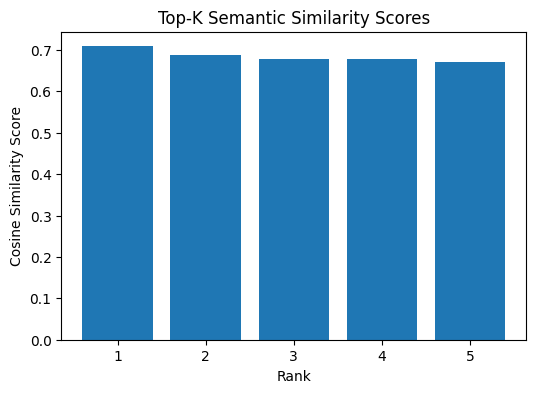

In [22]:
#Visualize top-K similarity scores
scores = [m["score"] for m in results["matches"]]

plt.figure(figsize=(6, 4))
plt.bar(range(1, len(scores) + 1), scores)
plt.xlabel("Rank")
plt.ylabel("Cosine Similarity Score")
plt.title("Top-K Semantic Similarity Scores")
plt.show()

The plot visualizes cosine similarity scores for the top-K retrieved contract chunks, showing a gradual decrease in relevance across ranks.

In [8]:
# Print results for RAG search
def pretty_print_results(results: List[Dict]):
    for i, res in enumerate(results, start=1):
        print(f"\nRank {i}")
        print("Similarity Score:", round(res["score"], 4))
        print("Contract ID:", res["contract_id"])
        print("Chunk ID:", res["chunk_id"])
        print("Text Preview:")
        print(res["text"][:400])


Displayed retrieved contract chunks with similarity scores and contextual previews for easy inspection.

In [15]:
# Test with a Real Legal Query
INDEX_NAME = "cuad-index-minilm"  
index = pc.Index(INDEX_NAME)
print("Connected to Pinecone index:", INDEX_NAME)

query = "termination clause with prior written notice"

rag_results = rag_search(query, index, top_k=5)
pretty_print_results(rag_results)

Connected to Pinecone index: cuad-index-minilm

Rank 1
Similarity Score: 0.6975
Contract ID: SUCAMPOPHARMACEUTICALS,INC_11_04_2015-EX-10.2-STRATEGIC ALLIANCE AGREEMENT_cleaned
Chunk ID: 79
Text Preview:
TERMINATION Section 6.01 Termination. This Agreement may be terminated prior to the end of the Offer Period by Acquiror if a condition for withdrawal of the Offer has occurred. This Agreement shall be automatically terminated if the Offer has been withdrawn or the Offer is not successful due to the failure of obtaining the minimum threshold. This Agreement may not be terminated after the end of th

Rank 2
Similarity Score: 0.6894
Contract ID: MRSFIELDSORIGINALCOOKIESINC_01_29_1998-EX-10-FRANCHISE AGREEMENT_cleaned
Chunk ID: 242
Text Preview:
19.C. EXTENSION OF NOTICE.

 If any applicable law or rule requires a greater prior notice of termination, the prior notice required by such law or rule shall be substituted for the notice requirements herein.

 19.D. REPEATED BREACHES.

Rank 3
Simi

The semantic search successfully retrieved contract clauses related to termination and notice requirements. Higher similarity scores indicate stronger contextual relevance between the query and retrieved contract chunks.

In [18]:
# Highlight Keywords in Retrieved Chunks
def highlight_keywords(text: str, keywords: List[str]):
    for kw in keywords:
        pattern = re.compile(rf"\b({re.escape(kw)})\b", re.IGNORECASE)
        text = pattern.sub(r"**\1**", text)
    return text

keywords = ["termination", "notice", "prior", "written"]

for i, res in enumerate(rag_results, start=1):
    print(f"\nRank {i} (Highlighted)")
    print(highlight_keywords(res["text"][:400], keywords))



Rank 1 (Highlighted)
**TERMINATION** Section 6.01 **Termination**. This Agreement may be terminated **prior** to the end of the Offer Period by Acquiror if a condition for withdrawal of the Offer has occurred. This Agreement shall be automatically terminated if the Offer has been withdrawn or the Offer is not successful due to the failure of obtaining the minimum threshold. This Agreement may not be terminated after the end of th

Rank 2 (Highlighted)
19.C. EXTENSION OF **NOTICE**.

 If any applicable law or rule requires a greater **prior** **notice** of **termination**, the **prior** **notice** required by such law or rule shall be substituted for the **notice** requirements herein.

 19.D. REPEATED BREACHES.

Rank 3 (Highlighted)
16. **TERMINATION**

16.1 **Termination** events: without prejudice to any other rights under this Agreement and/or at Law, either Party shall be entitled to terminate all or part of this Agreement by **Notice** of **termination**, as per Clauses 16.4 ("**

Key legal terms were highlighted within the retrieved chunks to enhance readability and validate relevance of termination-related clauses.

In [20]:
# Save Retrieval Results
OUTPUT_PATH = "rag_results_sample.json"

with open(OUTPUT_PATH, "w", encoding="utf-8") as f:
    json.dump(
        {
            "query": query,
            "results": rag_results
        },
        f,
        ensure_ascii=False,
        indent=2
    )

print(f"RAG results saved to {OUTPUT_PATH}")


RAG results saved to rag_results_sample.json


Saved retrieved RAG results to a JSON file for reproducibility and future agent-based processing.

In [3]:
from core.pinecone_utils import get_pinecone_client, create_or_connect_index

pc = get_pinecone_client()
index = create_or_connect_index(pc)


ModuleNotFoundError: No module named 'core'